In [ ]:
# # Re-clone after change
# import shutil
# shutil.rmtree('/kaggle/working/FinancialPhrase_Sentiment_Mistral7B')
# !git clone https://github.com/VA0211/FinancialPhrase_Sentiment_Mistral7B.git

In [1]:
!git clone https://github.com/VA0211/FinancialPhrase_Sentiment_Mistral7B.git
!pip install -r /kaggle/working/FinancialPhrase_Sentiment_Mistral7B/requirements.txt

Cloning into 'FinancialPhrase_Sentiment_Mistral7B'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 11 (delta 2), reused 10 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (11/11), done.
Resolving deltas: 100% (2/2), done.
  Obtaining dependency information for peft==0.7.1 from https://files.pythonhosted.org/packages/8b/1b/aee2a330d050c493642d59ba6af51f3910cb138ea48ede228c84c204a5af/peft-0.7.1-py3-none-any.whl.metadata
  Obtaining dependency information for bitsandbytes==0.41.3.post2 from https://files.pythonhosted.org/packages/d9/8d/b62d4fb02587e293e5b91b68bbcaa2d88c6a0360b622e9521d4bd07a20cd/bitsandbytes-0.41.3.post2-py3-none-any.whl.metadata
  Obtaining dependency information for transformers==4.36.1 from https://files.pythonhosted.org/packages/fc/04/0aad491cd98b09236c54ab849863ee85421eeda5138bbf9d33ecc594652b/transformers-4.36.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from transformers import (AutoModelForCausalLM, 
                          AutoTokenizer, 
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                          pipeline, 
                          logging)
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix)
from sklearn.model_selection import train_test_split

In [4]:
from shutil import copyfile

# copy file into the working directory
copyfile(src = "/kaggle/working/FinancialPhrase_Sentiment_Mistral7B/data.py", dst = "/kaggle/working/data.py")
copyfile(src = "/kaggle/working/FinancialPhrase_Sentiment_Mistral7B/utils.py", dst = "/kaggle/working/utils.py")
from data import generate_dataset, generate_prompt, generate_test_prompt
from utils import evaluate, predict

## Dataset
### Original dataset

In [5]:
file = '/kaggle/input/sentiment-analysis-for-financial-news/all-data.csv'
df = pd.read_csv(file, names=['sentiment', 'text'], encoding='utf-8', encoding_errors='replace')
df

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


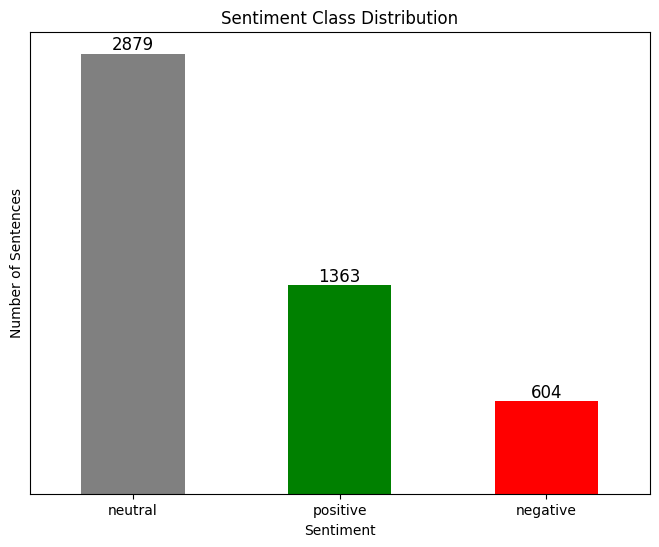

In [6]:
import matplotlib.pyplot as plt
custom_palette = {'positive': 'green', 'neutral': 'gray', 'negative': 'red'}

# Count the number of occurrences for each sentiment
sentiment_counts = df['sentiment'].value_counts()
colors = [custom_palette[sentiment] for sentiment in sentiment_counts.index]
# Plot the class distribution
plt.figure(figsize=(8,6))
bars = sentiment_counts.plot(kind='bar', color=colors)

# Annotate the bars with their respective values
for bar in bars.patches:
    bars.annotate(f'{bar.get_height()}', 
                  (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                  ha='center', va='bottom', fontsize=12)

# Set plot title and labels
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Sentences')
plt.xticks(rotation=0)
plt.yticks([]) 
# Show the plot
plt.show()

### Split data

In [7]:
X_train, X_eval, X_test, y_true = generate_dataset(file_path='/kaggle/input/sentiment-analysis-for-financial-news/all-data.csv', 
                                                   train_size=360,
                                                   val_size=60,
                                                   test_size=180)
X_train, X_eval, X_test

(     sentiment                                               text
 0      neutral  Compared with the FTSE 100 index , which rose ...
 1      neutral  The offer of some 30 million shares aimed to r...
 2     negative  Operating profit in the fourth quarter went do...
 3      neutral  The latest result included per-share charges o...
 4     negative    It is a disappointment to see the plan folded .
 ...        ...                                                ...
 1075  positive  Operating profit rose to EUR 13.1 mn from EUR ...
 1076   neutral  Construction work on the Helsinki Music Centre...
 1077  positive  Finnish consulting and engineering group Poyry...
 1078  negative  We have also cut our price projections for pap...
 1079  negative  Qualcomm estimated a first-quarter profit betw...
 
 [1080 rows x 2 columns],
     sentiment                                               text
 0    negative  The poorest index figure was given to Finnish ...
 1    negative  Profit before taxes 

           count       mean        std  min   25%   50%    75%   max
sentiment                                                           
negative   600.0  23.916667   9.918182  5.0  17.0  22.0  30.00  56.0
neutral    600.0  22.218333  10.119519  3.0  15.0  21.0  28.00  55.0
positive   600.0  24.605000   9.857701  5.0  17.0  23.0  30.25  57.0


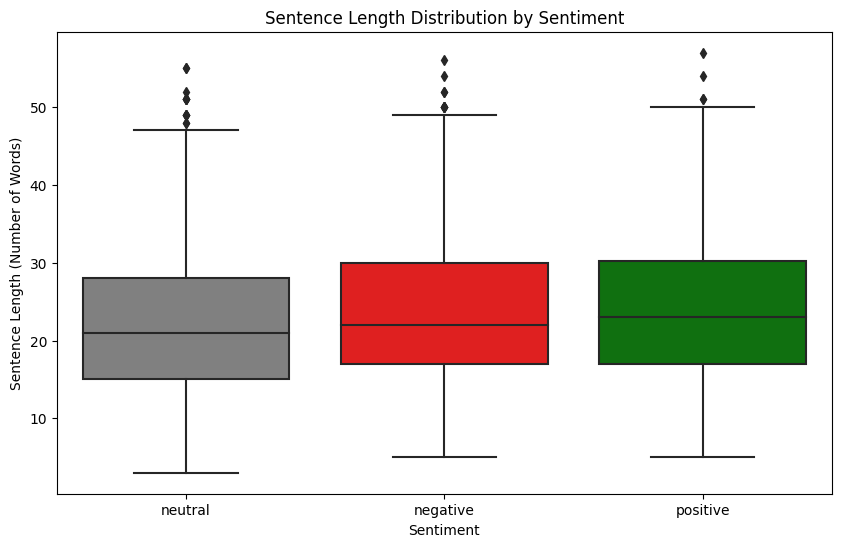

In [8]:
import seaborn as sns

tmp_df = pd.concat([X_train, X_eval, X_test], ignore_index=True)
# Calculate the length of each sentence in terms of word count
tmp_df['sentence_length'] = tmp_df['text'].apply(lambda x: len(x.split()))

# Print some stats for each sentiment
print(tmp_df.groupby('sentiment')['sentence_length'].describe())

# Visualize the distribution of sentence lengths with a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='sentence_length', data=tmp_df, palette=custom_palette)
plt.title('Sentence Length Distribution by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Sentence Length (Number of Words)')
plt.show()

## Add prompt to data

In [9]:
X_train = pd.DataFrame(X_train.apply(generate_prompt, axis=1), 
                       columns=["text"])
X_eval = pd.DataFrame(X_eval.apply(generate_prompt, axis=1), 
                      columns=["text"])

y_true = X_test.sentiment
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis=1), columns=["text"])

train_data = Dataset.from_pandas(X_train)
eval_data = Dataset.from_pandas(X_eval)

In [10]:
print(f"{train_data[0]}\n")
print(eval_data[0])

{'text': '[INST]Analyze the sentiment of the news headline enclosed in square brackets, \n            determine if it is positive, neutral, or negative, and return the answer as \n            the corresponding sentiment label "positive" or "neutral" or "negative"[/INST]\n\n            [Compared with the FTSE 100 index , which rose 51.5 points ( or 0.9 % ) on the day , this was a relative price change of -0.6 % .] = neutral'}

{'text': '[INST]Analyze the sentiment of the news headline enclosed in square brackets, \n            determine if it is positive, neutral, or negative, and return the answer as \n            the corresponding sentiment label "positive" or "neutral" or "negative"[/INST]\n\n            [The poorest index figure was given to Finnish power company Fortum , 4.5 .] = negative'}


## Load model

In [11]:
model_name = '/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1'

compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_use_double_quant = False,
    bnb_4bit_quant_type = "nf4",
    bnb_4bit_compute_dtype = compute_dtype
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map='auto',
    quantization_config=bnb_config
)

model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                          trust_remote_code=True,
                                          padding_side="left",
                                          add_eos_token=True,
                                         )
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Evaluate original model

In [12]:
y_pred = predict(X_test, model, tokenizer)

100%|██████████| 540/540 [03:42<00:00,  2.43it/s]


In [13]:
evaluate(y_true, y_pred)

Accuracy: 0.670
Accuracy for label 0: 0.928
Accuracy for label 1: 0.889
Accuracy for label 2: 0.194

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       180
           1       0.51      0.89      0.65       180
           2       0.83      0.19      0.32       180

    accuracy                           0.67       540
   macro avg       0.75      0.67      0.63       540
weighted avg       0.75      0.67      0.63       540


Confusion Matrix:
[[167  13   0]
 [ 13 160   7]
 [  5 140  35]]


## Fine-tunning

In [15]:
output_dir="trained_logs"

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)

training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=5,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8, # 4
    optim="paged_adamw_32bit",
    save_steps=0,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="cosine",
    report_to="tensorboard",
    evaluation_strategy="epoch"
)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    args=training_arguments,
    packing=False,
    max_seq_length=1024,
)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [16]:
# Train model
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,0.814100,0.831199
2,0.688000,0.838915
3,0.605800,0.825507
4,0.571200,0.841200
5,0.460700,0.854303


TrainOutput(global_step=675, training_loss=0.6973593365704571, metrics={'train_runtime': 4957.2292, 'train_samples_per_second': 1.089, 'train_steps_per_second': 0.136, 'total_flos': 2.486609708900352e+16, 'train_loss': 0.6973593365704571, 'epoch': 5.0})

In [17]:
y_pred = predict(X_test, model, tokenizer)
evaluate(y_true, y_pred)

100%|██████████| 540/540 [03:49<00:00,  2.35it/s]

Accuracy: 0.878
Accuracy for label 0: 0.956
Accuracy for label 1: 0.889
Accuracy for label 2: 0.789

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       180
           1       0.79      0.89      0.84       180
           2       0.89      0.79      0.84       180

    accuracy                           0.88       540
   macro avg       0.88      0.88      0.88       540
weighted avg       0.88      0.88      0.88       540


Confusion Matrix:
[[172   6   2]
 [  5 160  15]
 [  1  37 142]]


In [18]:
# Save trained model and tokenizer
trainer.save_model()
tokenizer.save_pretrained(output_dir)

('trained_logs/tokenizer_config.json',
 'trained_logs/special_tokens_map.json',
 'trained_logs/tokenizer.model',
 'trained_logs/added_tokens.json',
 'trained_logs/tokenizer.json')

## Clean memory and merging the weights 

In [19]:
import gc

del [model, tokenizer, peft_config, trainer, train_data, eval_data, bnb_config, training_arguments]
del [df, X_train, X_eval]
del [TrainingArguments, SFTTrainer, LoraConfig, BitsAndBytesConfig]

In [20]:
for _ in range(100):
    torch.cuda.empty_cache()
    gc.collect()

In [21]:
!nvidia-smi

Wed Oct 23 10:38:04 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P0             36W /  250W |     695MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"working on {device}")

working on cuda:0


In [23]:
from peft import AutoPeftModelForCausalLM

finetuned_model = "./trained_logs/"
compute_dtype = getattr(torch, "float16")
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoPeftModelForCausalLM.from_pretrained(
     finetuned_model,
     torch_dtype=compute_dtype,
     return_dict=False,
     low_cpu_mem_usage=True,
     device_map=device,
)

merged_model = model.merge_and_unload()
merged_model.save_pretrained("./merged_model",safe_serialization=True, max_shard_size="2GB")
tokenizer.save_pretrained("./merged_model")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

('./merged_model/tokenizer_config.json',
 './merged_model/special_tokens_map.json',
 './merged_model/tokenizer.model',
 './merged_model/added_tokens.json',
 './merged_model/tokenizer.json')

In [24]:
y_pred = predict(X_test, merged_model, tokenizer)
evaluate(y_true, y_pred)

100%|██████████| 540/540 [02:37<00:00,  3.43it/s]

Accuracy: 0.876
Accuracy for label 0: 0.950
Accuracy for label 1: 0.922
Accuracy for label 2: 0.756

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       180
           1       0.77      0.92      0.84       180
           2       0.91      0.76      0.83       180

    accuracy                           0.88       540
   macro avg       0.89      0.88      0.88       540
weighted avg       0.89      0.88      0.88       540


Confusion Matrix:
[[171   8   1]
 [  2 166  12]
 [  3  41 136]]
